# Breast cancer detection using histopathology images

## Overview  

Breast cancer is the most common type of cancer and the second leading cause of cancer death in women. There are more than 200,000 new cases every year in US. If a patient is suspected to have breast cancer during the regular screening, small amount of cancer tissue will be taken for further examination, and pathologists will examine the each tissue samples to determine cancer. This process is critical in cancer diagnosis, thus my goal for this project is to build a model to detect breast cancer using microscope images. This model could help pathologists to expedite diagnosis process and also patients to get treatment sooner.  
  
I found my dataset from Kaggle. The dataset consists with 198,738 cancer-negative and 78,786 cancer-positive images with labels.  
https://www.kaggle.com/paultimothymooney/breast-histopathology-images


In [0]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################

import numpy as np
import pandas as pd

from numpy.random import seed
seed(42)

%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import *
import keras

tf.random.set_seed(42)

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib
TensorFlow 2.x selected.


Using TensorFlow backend.


In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!nvidia-smi

Sun Mar 22 22:19:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |    265MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# #mount google drive to Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# getting reday for downloading dataset from Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jisong316","key":"b4ce852d688c7ce105a32610305f35b6"}'}

In [0]:
# set permission for downloading dataset from Kaggle
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [0]:
# downloading dataset
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [01:07<00:00, 86.4MB/s]
100% 3.10G/3.10G [01:07<00:00, 49.3MB/s]


In [0]:
# unzip the downloaded data
!unzip "/content/breast-histopathology-images.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2351_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/

## Exploring the data structure

In [0]:
# creating a list of patients ids from folder/file names
patients=os.listdir('/content/IDC_regular_ps50_idx5')

In [0]:
# number of patients?
len(patients)

279

In [0]:
!mkdir data
image_path="/content/data/"

In [0]:
# move all images to the same folder

# create a list of all patient id's
for patient in patients:
    
    path_0 = '/content/IDC_regular_ps50_idx5/' + str(patient) + '/0'
    path_1 = '/content/IDC_regular_ps50_idx5/' + str(patient) + '/1'


    # create a list of all files in folder 0
    file_list_0 = os.listdir(path_0)
    # create a list of list all file in folder 1
    file_list_1 = os.listdir(path_1)

    # move the 0 images to all_images_dir
    for fname in file_list_0:

        # source path to image
        src = os.path.join(path_0, fname)
        # destination path to image
        dst = os.path.join(image_path, fname)
        # copy the image from the source to the destination
        shutil.move(src, dst)


    # move the 1 images to data
    for fname in file_list_1:

        # source path to image
        src = os.path.join(path_1, fname)
        # destination path to image
        dst = os.path.join(image_path, fname)
        # copy the image from the source to the destination
        shutil.move(src, dst)

In [0]:
# number of images?
len(os.listdir('data'))

277524

In [0]:
!rm -rf IDC_regular_ps50_idx5/

In [0]:
# make a list of images
image_list = os.listdir('data')

df = pd.DataFrame(image_list, columns=['image_id'])

df.head()

,image_id
0,15634_idx5_x851_y1501_class1.png
1,9077_idx5_x1551_y501_class1.png
2,12749_idx5_x2201_y851_class1.png
3,9291_idx5_x1351_y1201_class0.png
4,12955_idx5_x1151_y2401_class0.png


In [0]:
# extracting patient ids from the image list
df['patient_id'] = df['image_id'].str.split('_').str[0]

# extracting target values
df['target'] = df['image_id'].str[-5]

In [0]:
image_path = 'data/'

## Data preprocessing

In [0]:
# take a sample of the majority class 0 (total = 198738)
df_0 = df[df['target'] == '0'].sample(df['target'].value_counts()[1], random_state=42)
# take a sample of class 1 (total = 78786)
df_1 = df[df['target'] == '1']

# concat the two dataframes
df_bal = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# Check the new class distribution
df_bal['target'].value_counts()


1    78786
0    78786
Name: target, dtype: int64

In [0]:
y = df_bal['target']

df_train_val, df_test = train_test_split(df_bal, test_size=0.2, random_state=42, stratify=y)

print(df_train_val.shape)
print(df_test.shape)

(126057, 3)
(31515, 3)


In [0]:
y_train_val = df_train_val['target']
df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print(df_train.shape)
print(df_val.shape)

(100845, 3)
(25212, 3)


In [0]:
# make directory to store train, val, test set images
!mkdir train
!mkdir train/negative
!mkdir train/positive
!mkdir val
!mkdir val/negative
!mkdir val/positive
!mkdir test
!mkdir test/negative
!mkdir test/positive

In [0]:
# Set the id as the index
df_bal.set_index('image_id', inplace=True)

In [0]:
# Get a list of train, val, test images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])

In [0]:
train_path='/content/train'
val_path='/content/val'
test_path='/content/test'

In [0]:
df.set_index('image_id', inplace=True)

In [0]:
for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'negative'
    if target == '1':
        label = 'positive'
    
    # source path to image
    src = os.path.join(image_path, fname)
    # destination path to image
    dst = os.path.join(train_path, label, fname)
    # move the image from the source to the destination
    shutil.copyfile(src, dst)

In [0]:
for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'negative'
    if target == '1':
        label = 'positive'
    
    # source path to image
    src = os.path.join(image_path, fname)
    # destination path to image
    dst = os.path.join(val_path, label, fname)
    # move the image from the source to the destination
    shutil.copyfile(src, dst)

In [0]:
for image in test_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'negative'
    if target == '1':
        label = 'positive'
    
    # source path to image
    src = os.path.join(image_path, fname)
    # destination path to image
    dst = os.path.join(test_path, label, fname)
    # move the image from the source to the destination
    shutil.copyfile(src, dst)

In [0]:
num_train_samples=len(df_train)
num_val_samples=len(df_val)
num_test_samples=len(df_test)

train_steps = np.ceil(num_train_samples/10)
val_steps = np.ceil(num_val_samples/10)
test_steps = np.ceil(num_test_samples/10)

In [0]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(50,50),
                                        batch_size=10,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(val_path,
                                      target_size=(50,50),
                                      batch_size=10,
                                      class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(test_path,
                                       target_size=(50,50),
                                       batch_size=10,
                                       class_mode='categorical',
                                       shuffle=False)


Found 100845 images belonging to 2 classes.
Found 25212 images belonging to 2 classes.
Found 31515 images belonging to 2 classes.


In [0]:
def create_model():
  kernel_size=(3,3)
  pool_size=(2,2)
  first_filters=32
  second_filters=64
  third_filters= 128

  model=Sequential()
  model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape=(50,50,3)))
  model.add(MaxPooling2D(pool_size=pool_size)) 
                    
  model.add(Conv2D(second_filters, kernel_size, activation='relu'))
  model.add(MaxPooling2D(pool_size=pool_size))
                    
  model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
  model.add(MaxPooling2D(pool_size=pool_size))
                    
  model.add(Flatten())
  model.add(Dense(256,activation="relu"))
  model.add(Dense(2,activation="sigmoid"))
 
  model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])
  return model

In [0]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [0]:
model.layers

In [0]:
len(model.layers)

9

In [0]:
checkpoint_path = "/content/drive/My Drive/cancer/training-2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# checkpoint callback
cp_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                               save_weights_only=True,
                                               verbose=1)

In [0]:
model=create_model()

history=model.fit(train_gen, steps_per_epoch=train_steps, 
                  validation_data=val_gen,
                  validation_steps=val_steps,epochs=30, verbose=1,
                  callbacks=[cp_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10085.0 steps, validate for 2522.0 steps
Epoch 1/30
10084/10085 [============================>.] - ETA: 0s - loss: 0.4573 - auc_1: 0.8666 - recall_1: 0.7950
Epoch 00001: saving model to /content/drive/My Drive/cancer/training-2/cp.ckpt
10085/10085 [==============================] - 128s 13ms/step - loss: 0.4573 - auc_1: 0.8666 - recall_1: 0.7950 - val_loss: 0.4350 - val_auc_1: 0.8822 - val_recall_1: 0.8027
Epoch 2/30
10081/10085 [============================>.] - ETA: 0s - loss: 0.4127 - auc_1: 0.8934 - recall_1: 0.8192
Epoch 00002: saving model to /content/drive/My Drive/cancer/training-2/cp.ckpt
10085/10085 [==============================] - 119s 12ms/step - loss: 0.4127 - auc_1: 0.8934 - recall_1: 0.8192 - val_loss: 0.3891 - val_auc_1: 0.9078 - val_recall_1: 0.8321
Epoch 3/30
10079/10085 [============================>.] - ETA: 0s - loss: 0.3899 - auc_1: 0.9054 - recall_1: 0.8319
Epoch 00003: saving model to /content/drive/M

In [0]:
model.save('/content/drive/My Drive/cancer/l9_e30.h5')

In [0]:
model.metrics_names

['loss', 'auc_1', 'recall_1']

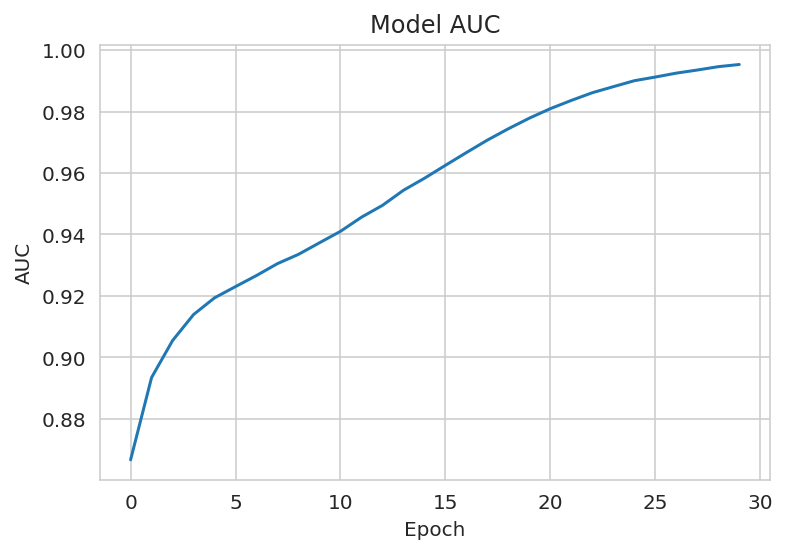

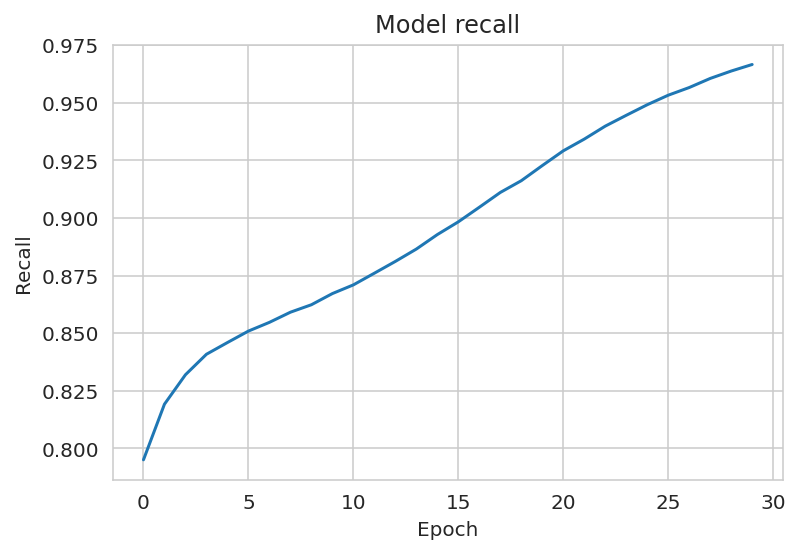

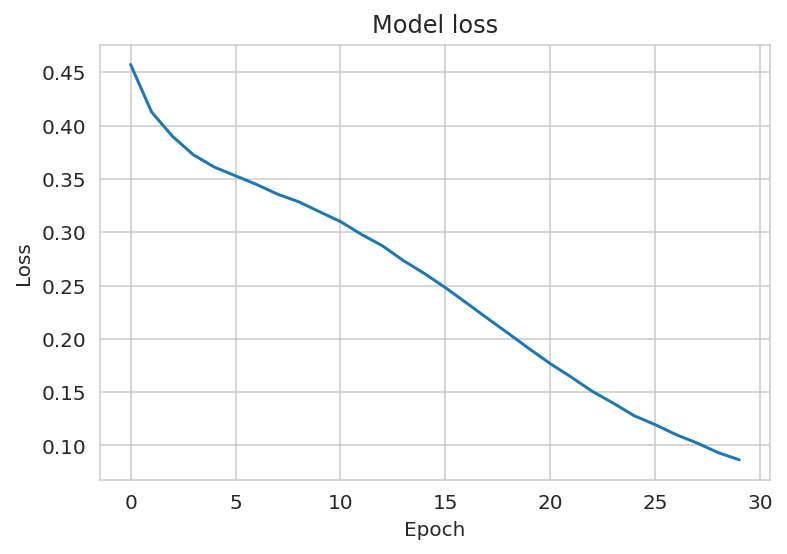

In [0]:
# Plot training & validation AUC values
plt.plot(history.history['auc_1'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation recall values
plt.plot(history.history['recall_1'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

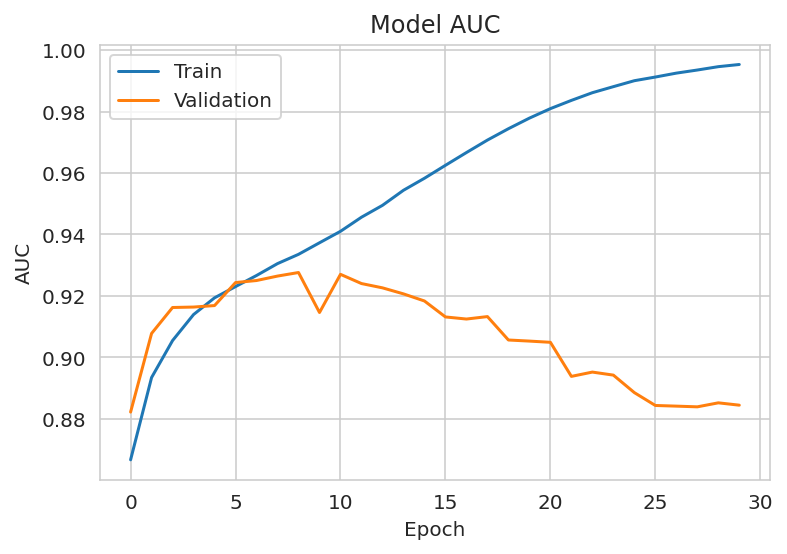

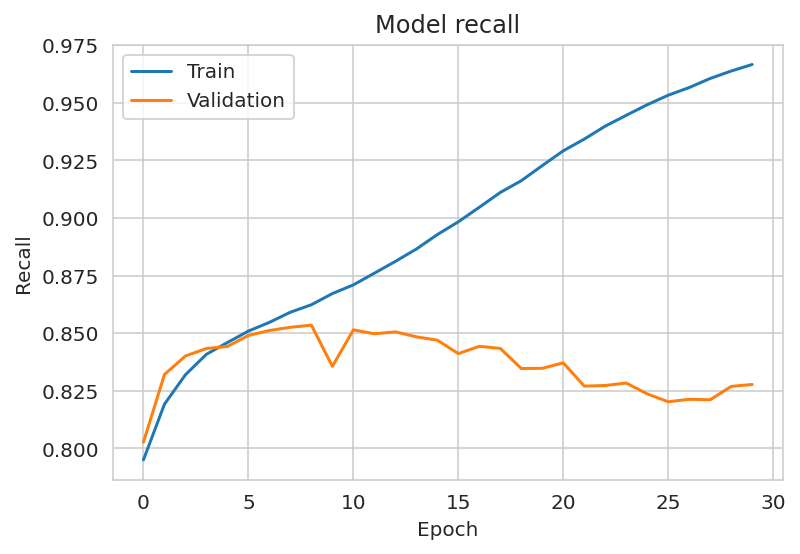

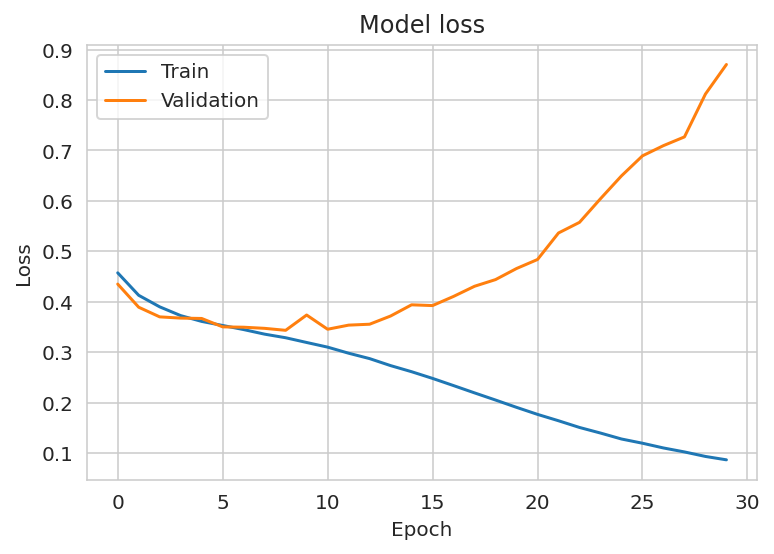

In [0]:
# Plot training & validation AUC values
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
model.load_weights(checkpoint_path)
test_loss_w, test_auc_w, test_recall_w = model.evaluate(test_gen, steps=len(df_test))

print('test_loss:', test_loss_w)
print('test_auc:', test_auc_w)
print('test_recall:', test_recall_w)

  ...
    to  
  ['...']
 3152/31515 [==>...........................] - ETA: 3:55 - loss: 0.8845 - auc_1: 0.8830 - recall_1: 0.8266test_loss: 0.08849402831545718
test_auc: 0.8830243
test_recall: 0.82655877


In [0]:
predictions = model.predict(test_gen, verbose=1)

3152/3152 [==============================] - 19s 6ms/step


In [0]:
predictions.shape

(31515, 2)

In [0]:
test_gen.class_indices

{'negative': 0, 'positive': 1}

In [0]:
df_preds = pd.DataFrame(predictions, columns=['Not cancer', 'Cancer'])

df_preds.head()

,Not cancer,Cancer
0,1.000000e+00,1.584580e-08
1,3.771891e-07,9.999995e-01
2,3.802025e-03,9.959336e-01
3,9.986847e-01,1.422956e-03
4,9.884759e-01,1.313678e-02


In [0]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['Cancer']

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.8950367244214616

In [0]:
test_labels = test_gen.classes

In [0]:
test_labels.shape

(31515,)

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=20):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="RdPu", annot_kws={"fontsize":20})
      
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label', size=25)
    plt.xlabel('Predicted label', size=25)
    return fig

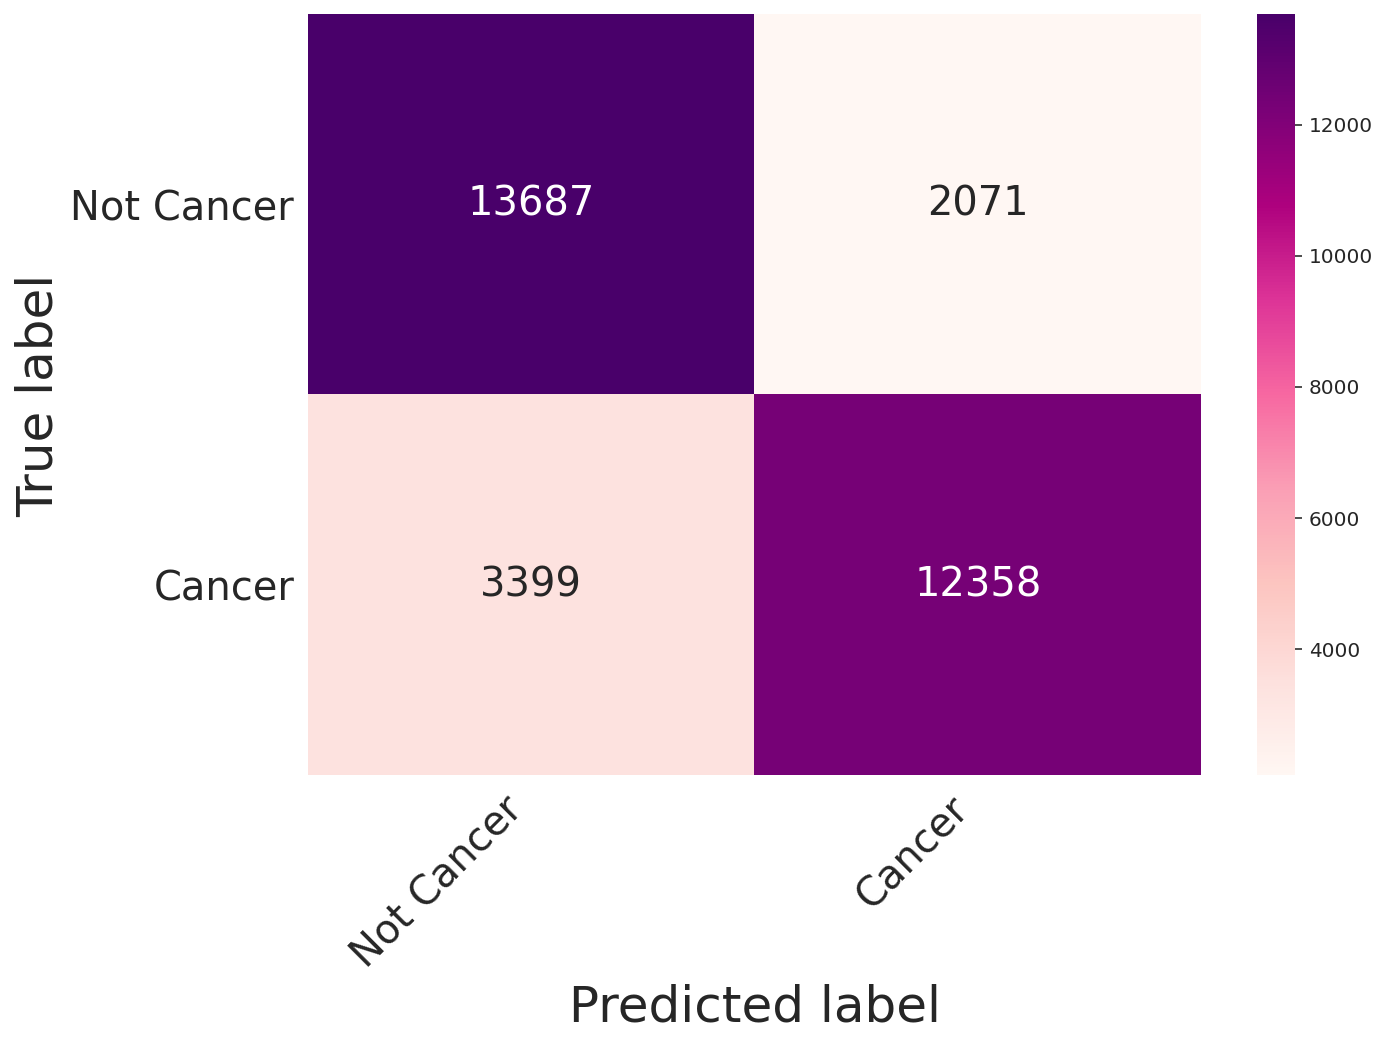

In [0]:
cm = print_confusion_matrix(confusion_matrix(test_labels, predictions.argmax(axis=1)), ['Not Cancer', 'Cancer'])

In [0]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred)

In [0]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [0]:
df_test=pd.read_csv('/content/drive/My Drive/cancer/df_test_t.csv')

In [0]:
del df_test['Unnamed: 0']

In [0]:
y_test=df_test['labels']
X_test=df_test.loc[:, ~df_test.columns.isin(['labels'])]

In [0]:
# Load pre-trained/tuned models
import pickle

model_names = ["lr_model", "nb_model", "rf_model", "et_model"]

for model_name in model_names:
    with open(f"/content/drive/My Drive/cancer/models/{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

ROC AUC score for LR model =  0.8897151805071508
ROC AUC score for NB model =  0.8703454921164622
ROC AUC score for RF model =  0.9420177981041116
ROC AUC score for ET model =  0.9443282200076306
ROC AUC score for NN model =  0.8950367244214616


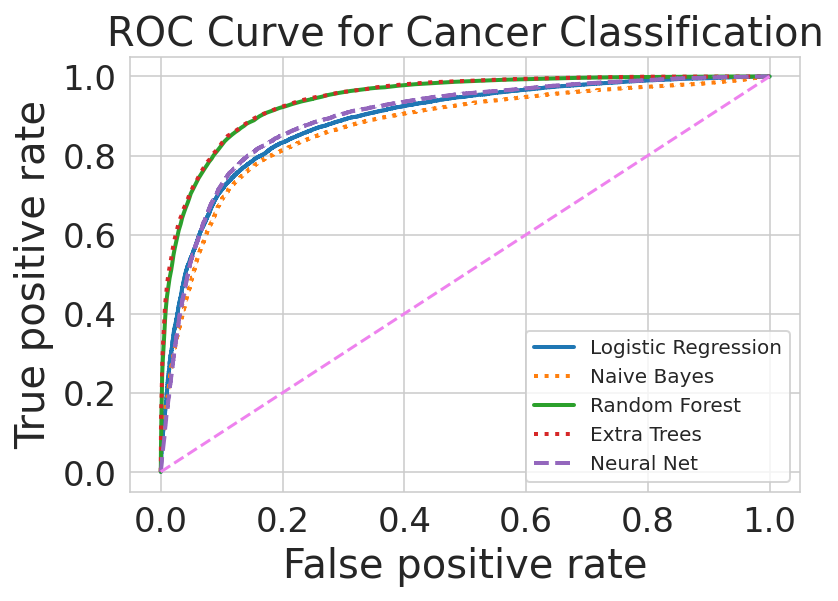

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)

fpr1, tpr1, thresholds1 = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
fpr4, tpr4, thresholds4 = roc_curve(y_test, et_model.predict_proba(X_test)[:,1])
fpr5, tpr5, thresholds5 = roc_curve(test_labels, y_pred)

plt.plot(fpr1, tpr1,lw=2,label='Logistic Regression')
plt.plot(fpr2, tpr2,lw=2, ls=':',label='Naive Bayes')
plt.plot(fpr3, tpr3,lw=2, ls='-', label='Random Forest')
plt.plot(fpr4, tpr4,lw=2, ls=':', label='Extra Trees')
plt.plot(fpr5, tpr5,lw=2, ls='--', label='Neural Net')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0], fontsize = 17)
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0], fontsize = 17)

plt.xlabel('False positive rate', size=20)
plt.ylabel('True positive rate', size=20)
plt.title('ROC Curve for Cancer Classification', size=20)
plt.legend(loc='lower right')

print("ROC AUC score for LR model = ", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1]))
print("ROC AUC score for NB model = ", roc_auc_score(y_test, nb_model.predict_proba(X_test)[:,1]))
print("ROC AUC score for RF model = ", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))
print("ROC AUC score for ET model = ", roc_auc_score(y_test, et_model.predict_proba(X_test)[:,1]))
print("ROC AUC score for NN model = ", roc_auc_score(y_true, y_pred))
plt.savefig('/content/drive/My Drive/cancer/roc_model_comparison_NN-test_set-1.svg')
